In [1]:
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.optimizers import *

from utils import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

c:\users\rafae\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Construindo Redes Neurais Recorrentes

### Primeira camada recorrente

Neste exemplo a camada recorrente irá processar todos os tempos de entrada e a saída será o estado h do último tempo (batch_size, output_features), gerando uma saída sem a dimensão temporal


Tente alterar o tamanho do estado H para ver a diferença no número de parâmetros

In [2]:
#O tamanho da entrada X é de 10 váriaveis com 100 tempos
inputs = Input((100, 10))
#Uma camada recorrente com estado h de tamanho 32
rnn = SimpleRNN(32)


out = rnn(inputs)

model = Model(inputs,out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 10)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1376      
Total params: 1,376
Trainable params: 1,376
Non-trainable params: 0
_________________________________________________________________


Quando queremos múltiplas saídas que mantenham a dimensão temporal devemos indicar ao Keras essa especifícação. Assim temos uma saída (batch_size, timesteps, output_features))

In [3]:
inputs = Input((100, 10))
#Return sequences indica para o Keras que a camada deve retornar o estado h em cada tempo
rnn = SimpleRNN(32, return_sequences=True)


out = rnn(inputs)

model = Model(inputs,out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 10)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 32)           1376      
Total params: 1,376
Trainable params: 1,376
Non-trainable params: 0
_________________________________________________________________


Em vários casos vaos precisar empilhar várias camadas para lidar com problemas complexos. Neste caso é necessário definir que cada camada intermediaria deve retornar todos os tempo para a próxima

In [4]:
inputs = Input((100, 10))
rnn = SimpleRNN(32, return_sequences=True)
rnn2 = SimpleRNN(32, return_sequences=True)
rnn3 = SimpleRNN(32, return_sequences=True)
rnn4 = SimpleRNN(32)   #A última gera uma saída sem dimensão temporal


x = rnn(inputs)
x = rnn2(x)
x = rnn3(x)
out = rnn4(x)

model = Model(inputs,out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 10)           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100, 32)           1376      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 100, 32)           2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 100, 32)           2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 7,616
Trainable params: 7,616
Non-trainable params: 0
_________________________________________________________________


### Classificação de textos com dataset do IMDB

Agora vamos treinar alguns modelos para fazer a classificação de textos entre positivos e negativos

In [5]:
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np

max_features = 10000  # número máximo de palavras a serem consideradas
maxlen = 100  #limite de tamanho dos textos

print('Carregando dataset...')
text_file = open("neg.csv", "r",encoding='utf-8')
neg_lines = text_file.readlines()
text_file = open("pos.csv", "r",encoding='utf-8')
pos_lines = text_file.readlines()

#cria uma lista com todos os textos
data = neg_lines + pos_lines
#cria um vetor indicando as saidas com 0 para textos negativos e 1 para positivos
y = np.array(np.hstack((np.zeros(len(neg_lines)),np.ones(len(pos_lines)))))

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

#Lê todos os textos e identifica o tamanho do vocabulário
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(data)

vocab_size = max_features + 1
print("Número de palavras:",len(tokenizer.word_counts))
print("Número de documentos:",tokenizer.document_count)
print("Texto:",data[5])

#Transforma o texto em sequência de tokens
data = tokenizer.texts_to_sequences(data)

for i, t in enumerate(data):
    if len(t) > maxlen:
        del data[i]
        y = np.delete(y, i)

print("Tokens:",data[5])

#Faz o padding das sequências
data = sequence.pad_sequences(data, maxlen=maxlen)
print("Sequências:",data[5])

Carregando dataset...
Número de palavras: 88582
Número de documentos: 25000
Texto: """It appears that many critics find the idea of a Woody Allen drama unpalatable."" And for good reason: they are unbearably wooden and pretentious imitations of Bergman. And let's not kid ourselves: critics were mostly supportive of Allen's Bergman pretensions, Allen's whining accusations to the contrary notwithstanding. What I don't get is this: why was Allen generally applauded for his originality in imitating Bergman, but the contemporaneous Brian DePalma was excoriated for ""ripping off"" Hitchcock in his suspense/horror films? In Robin Wood's view, it's a strange form of cultural snobbery. I would have to agree with that."

Tokens: [11, 19, 6, 28, 1459, 3792, 720, 6, 1251, 413, 8, 24, 203, 75, 877, 2, 24, 937, 6, 41, 14, 14, 9, 67, 27, 206, 24, 162, 257, 74, 312, 1, 1768, 7, 7, 1, 246, 148, 6, 2289, 931, 10, 37, 51, 237, 2877, 174, 26, 295, 1, 4043, 3, 4677, 129, 8, 1092, 1144, 34, 295, 1030, 4202,

Vamos criar nosso modelo com processamento recorrente

In [16]:
inputs = Input((maxlen,))
emb = Embedding(vocab_size, 32, input_length=maxlen)
rnn = SimpleRNN(4)


x = emb(inputs)
x = rnn(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs,out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.05, random_state=42)

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(X_test,y_test))

Train on 12765 samples, validate on 672 samples
Epoch 1/10
12765/12765 [==============================] - 3s 257us/step - loss: 0.6805 - acc: 0.5775 - val_loss: 0.6650 - val_acc: 0.6205
Epoch 2/10
12765/12765 [==============================] - 2s 172us/step - loss: 0.5949 - acc: 0.7883 - val_loss: 0.6009 - val_acc: 0.7619
Epoch 3/10
12765/12765 [==============================] - 2s 171us/step - loss: 0.5011 - acc: 0.8703 - val_loss: 0.5377 - val_acc: 0.7991
Epoch 4/10
12765/12765 [==============================] - 2s 173us/step - loss: 0.4087 - acc: 0.9130 - val_loss: 0.5025 - val_acc: 0.7902
Epoch 5/10
12765/12765 [==============================] - 2s 176us/step - loss: 0.3492 - acc: 0.9235 - val_loss: 0.4790 - val_acc: 0.8065
Epoch 6/10
12765/12765 [==============================] - 2s 184us/step - loss: 0.3059 - acc: 0.9347 - val_loss: 0.4528 - val_acc: 0.8185
Epoch 7/10
12765/12765 [==============================] - 2s 179us/step - loss: 0.2691 - acc: 0.9429 - val_loss: 0.4620 - va

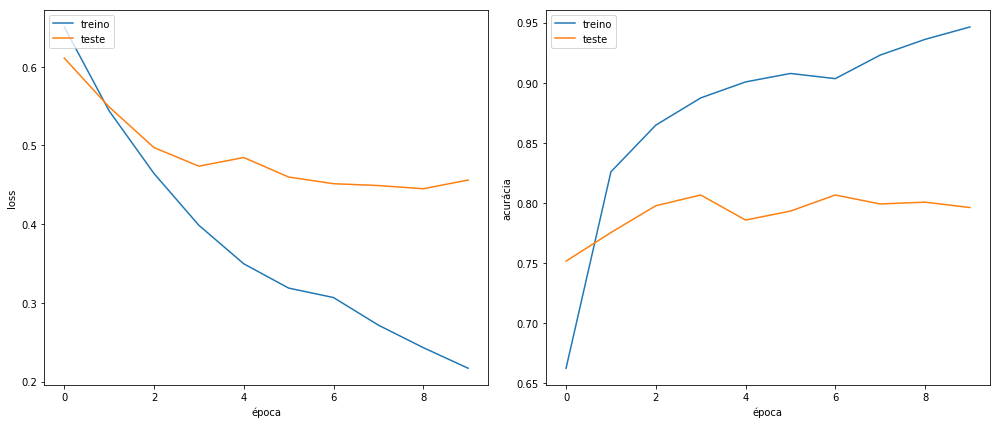

In [8]:
plot_history(history)

## Vamos tentar com a LSTM

In [6]:
from keras.layers import CuDNNLSTM, Dense
import matplotlib.pyplot as plt

inputs = Input((maxlen,))
emb_lstm = Embedding(vocab_size, 32, input_length=maxlen)
lstm = LSTM(8)

x = emb_lstm(inputs)
x = lstm(x)
out = Dense(1, activation='sigmoid')(x)

model_lstm = Model([inputs],out)
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 32)           320032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 321,353
Trainable params: 321,353
Non-trainable params: 0
_________________________________________________________________


Train on 12765 samples, validate on 672 samples
Epoch 1/10
12765/12765 [==============================] - 3s 200us/step - loss: 0.6805 - acc: 0.6037 - val_loss: 0.6316 - val_acc: 0.6369
Epoch 2/10
12765/12765 [==============================] - 1s 93us/step - loss: 0.5004 - acc: 0.8018 - val_loss: 0.4637 - val_acc: 0.8051
Epoch 3/10
12765/12765 [==============================] - 1s 95us/step - loss: 0.3600 - acc: 0.8802 - val_loss: 0.4054 - val_acc: 0.8318
Epoch 4/10
12765/12765 [==============================] - 1s 94us/step - loss: 0.2777 - acc: 0.9136 - val_loss: 0.3811 - val_acc: 0.8318
Epoch 5/10
12765/12765 [==============================] - 1s 93us/step - loss: 0.2232 - acc: 0.9349 - val_loss: 0.3848 - val_acc: 0.8438
Epoch 6/10
12765/12765 [==============================] - 1s 94us/step - loss: 0.1822 - acc: 0.9503 - val_loss: 0.3888 - val_acc: 0.8423
Epoch 7/10
12765/12765 [==============================] - 1s 92us/step - loss: 0.1481 - acc: 0.9626 - val_loss: 0.4434 - val_acc:

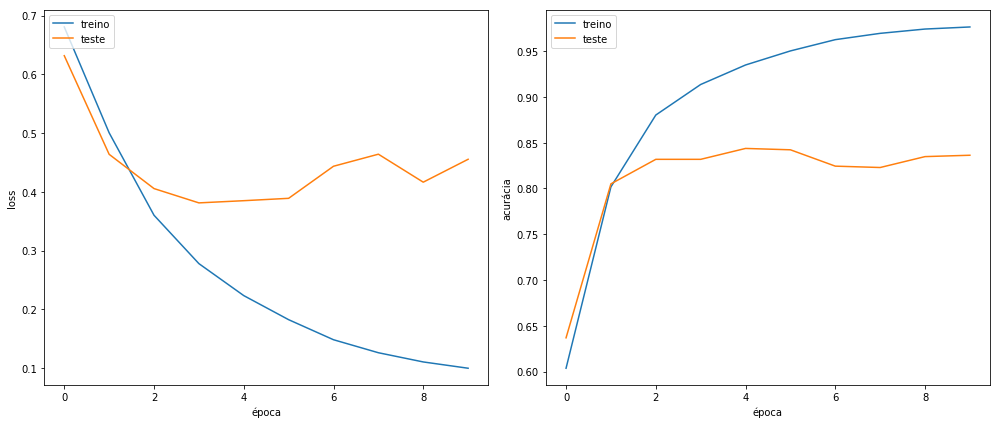

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.05, random_state=42)

history = model_lstm.fit(X_train, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(X_test,y_test))
model_lstm.save_weights('LSTM_imdb.h5')


plot_history(history)

In [7]:
#carrega pesos pré treinados
model_lstm.load_weights('LSTM_imdb.h5')

E com a GRU também

In [8]:
inputs = Input((maxlen,))
emb_gru = Embedding(vocab_size, 32, input_length=maxlen)
gru = GRU(8)

x = emb_gru(inputs)
x = gru(x)
out = Dense(1, activation='sigmoid')(x)

model_gru = Model([inputs],out)
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 32)           320032    
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 984       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 321,025
Trainable params: 321,025
Non-trainable params: 0
_________________________________________________________________


Train on 12765 samples, validate on 672 samples
Epoch 1/10
12765/12765 [==============================] - 8s 648us/step - loss: 0.6868 - acc: 0.5850 - val_loss: 0.6786 - val_acc: 0.6012
Epoch 2/10
12765/12765 [==============================] - 7s 556us/step - loss: 0.6254 - acc: 0.7254 - val_loss: 0.5784 - val_acc: 0.6920
Epoch 3/10
12765/12765 [==============================] - 7s 552us/step - loss: 0.4319 - acc: 0.8242 - val_loss: 0.4562 - val_acc: 0.7872
Epoch 4/10
12765/12765 [==============================] - 7s 546us/step - loss: 0.3246 - acc: 0.8785 - val_loss: 0.4298 - val_acc: 0.7961
Epoch 5/10
12765/12765 [==============================] - 7s 545us/step - loss: 0.2675 - acc: 0.9040 - val_loss: 0.4370 - val_acc: 0.7961
Epoch 6/10
12765/12765 [==============================] - 7s 551us/step - loss: 0.2295 - acc: 0.9179 - val_loss: 0.4503 - val_acc: 0.7902
Epoch 7/10
12765/12765 [==============================] - 7s 554us/step - loss: 0.2045 - acc: 0.9313 - val_loss: 0.4442 - va

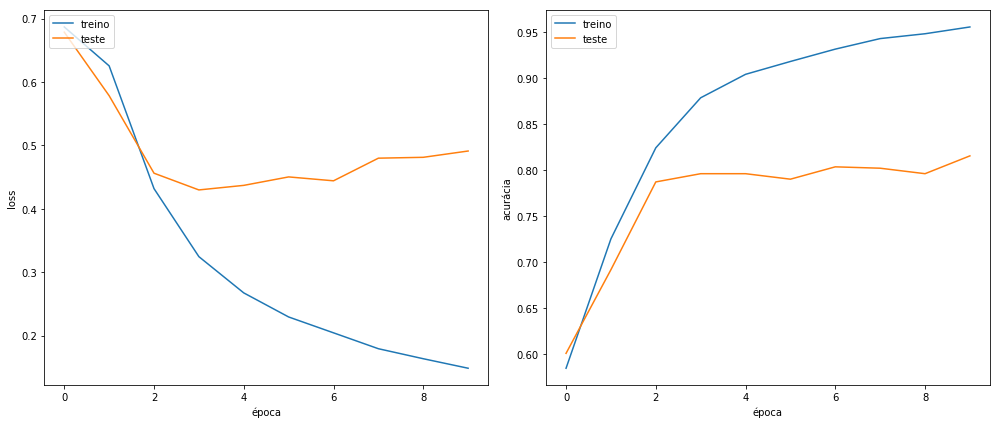

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.05, random_state=42)

history = model_gru.fit(X_train, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(X_test,y_test))
model_gru.save_weights('GRU_imdb.h5')

plot_history(history)

In [11]:
#carrega pesos pré treinados
model_gru.load_weights('GRU_imdb.h5')

Agora vamos criar uma visualização dos estados da camada recorrente enquanto ela lê as palavras.

Isso nos permite visualizar o efeito de cada palavra na memória da rede

In [12]:
#cria um dicionário invertido de token para palavras
index_word = {v: k for k, v in tokenizer.word_index.items()}

def test_lstm(texto):
    #Transforma o texto em sequências
    texto_token = tokenizer.texts_to_sequences([texto])
    t = sequence.pad_sequences(texto_token, maxlen=maxlen)
    
    inputs = Input((maxlen,))

    #indica que a lstm deve retornar todos os estados
    lstm.return_sequences = True
    

    x = emb_lstm(inputs)
    x = lstm(x)

    model2 = Model([inputs],x)
    model2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    pred = model2.predict(t)
    
    tam = len(texto_token[0]) + 5
    
    #recria o texto de entrada com base no vocabulário do tokenizer
    words = []
    for i in reversed(range(maxlen)):
        if index_word.get(t[0][i]):
            words.append(index_word.get(t[0][i]))
        else:
            if i <  (maxlen-tam):
                break
            words.append(' ')
        
    #plota os estados com cada coluna sendo um tempo de recorrência
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(4, 8),dpi=120)
    plt.imshow((pred[0,-tam:,:]), cmap='bwr_r')
    plt.yticks(np.arange(tam), reversed(words), rotation=0)
    plt.show()
    print("Grau de positividade: ", model_lstm.predict(t)[0][0])

    
def test_gru(texto):
    #Transforma o texto em sequências
    texto_token = tokenizer.texts_to_sequences([texto])
    t = sequence.pad_sequences(texto_token, maxlen=maxlen)
    
    inputs = Input((maxlen,))

    #indica que a Gru deve retornar todos os estados
    gru.return_sequences = True
    

    x = emb_gru(inputs)
    x = gru(x)

    model2 = Model([inputs],x)
    model2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    pred = model2.predict(t)
    
    tam = len(texto_token[0]) + 5
    
    #recria o texto de entrada com base no vocabulário do tokenizer
    words = []
    for i in reversed(range(maxlen)):
        if index_word.get(t[0][i]):
            words.append(index_word.get(t[0][i]))
        else:
            if i <  (maxlen-tam):
                break
            words.append(' ')
        
    #plota os estados com cada coluna sendo um tempo de recorrência
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(4, 8),dpi=120)
    plt.imshow((pred[0,-tam:,:]), cmap='bwr_r')
    plt.yticks(np.arange(tam), reversed(words), rotation=0)
    plt.show()
    print("Grau de positividade: ", model_gru.predict(t)[0][0])

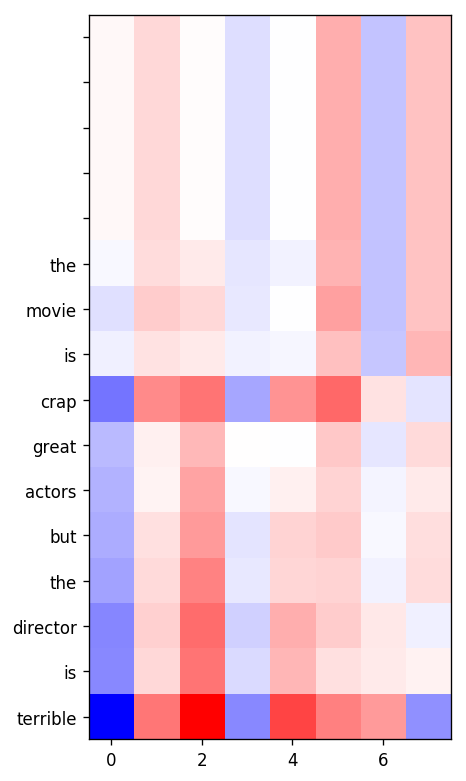

Grau de positividade:  0.10817402


In [13]:
test_lstm('the movie is crap, great actors, but the director is terrible')

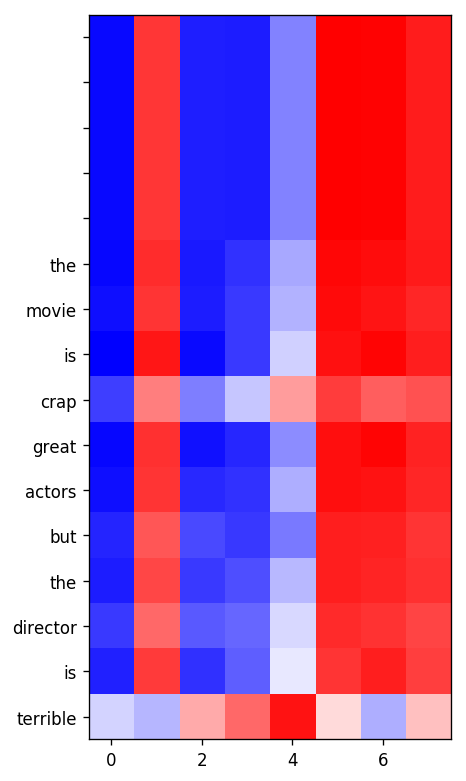

Grau de positividade:  0.17468494


In [14]:
test_gru('the movie is crap, great actors, but the director is terrible')

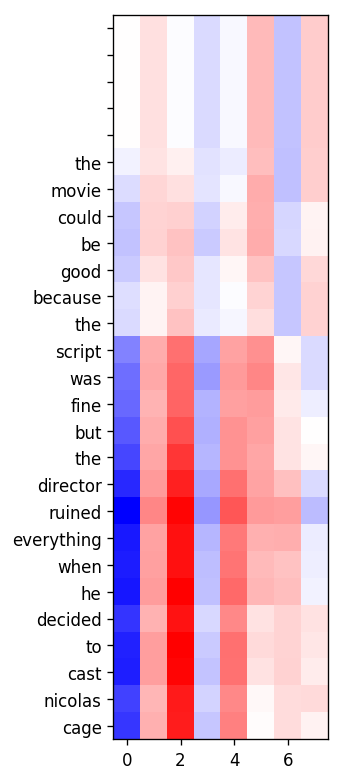

Grau de positividade:  0.18361714


In [15]:
test_lstm('The movie could be good because the script was fine, but the director ruined everything when he decided to cast Nicolas Cage')

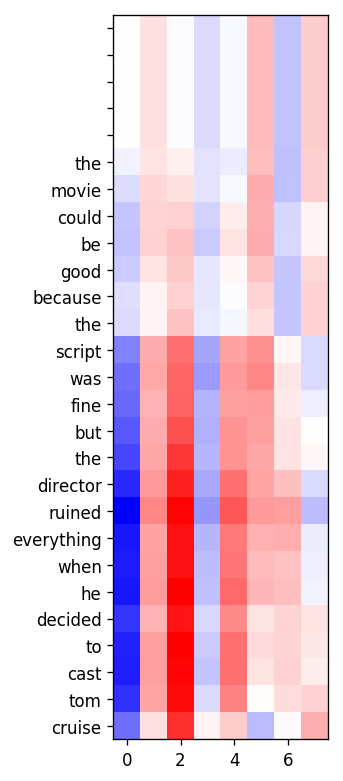

Grau de positividade:  0.29363385


In [16]:
test_lstm('The movie could be good because the script was fine, but the director ruined everything when he decided to cast Tom Cruise')

### Agora vamos visualizar o efeita da camada recorrente em cada amostra dos textos

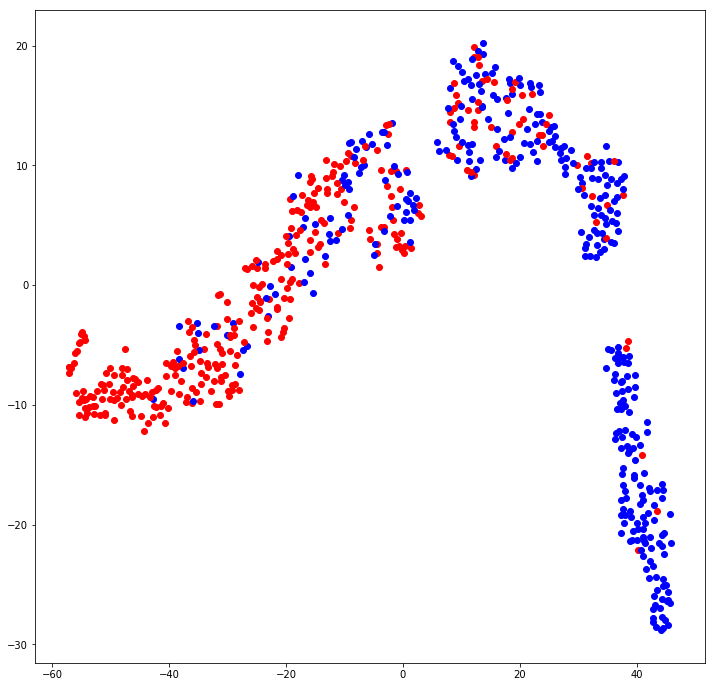

In [17]:
%matplotlib inline
lstm.return_sequences=False

x = emb_lstm(inputs)
x = lstm(x)

model2 = Model([inputs],x)
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


pred = model2.predict(X_test)

tsne = TSNE(n_components=2, init='pca', random_state=0)
low_dim_embedding = tsne.fit_transform(pred)

plt.figure(figsize=(12, 12))  # in inches

for i, label in enumerate(y_test):
    x, Y = low_dim_embedding[i, :]
    if label == 1:
        plt.scatter(x, Y, c = 'blue')
    else:
        plt.scatter(x, Y, c= 'red')


plt.show()


### Essa segunda visualização nos permite ver os textos

<IPython.core.display.Javascript object>


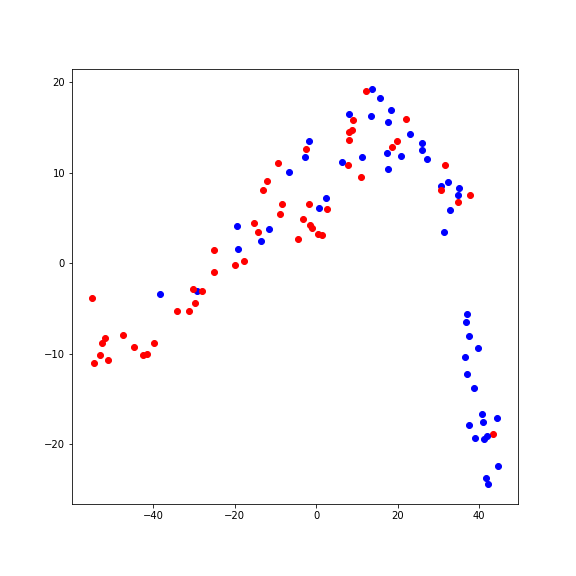

In [19]:
%matplotlib notebook

index_word = {v: k for k, v in tokenizer.word_index.items()}
text_file = open("neg.csv", "r",encoding='utf-8')
neg_lines = text_file.readlines()
text_file = open("pos.csv", "r",encoding='utf-8')
pos_lines = text_file.readlines()

#cria uma lista com todos os textos
texts = neg_lines + pos_lines
texts = tokenizer.texts_to_sequences(texts)


texts2 = []

for t in texts:
    texts2.append('')
    i = 0
    for word in t:
        if i ==0:
            texts2[-1] = texts2[-1] + (index_word.get(word))
            i+=1
        else:
            texts2[-1] = texts2[-1] + ' ' + (index_word.get(word))
            
            
texts_train, texts_test = train_test_split(texts2, test_size=0.05, random_state=42)

def on_move(event):
    visibility_changed = False
    for point, annotation in points_with_annotation:
        should_be_visible = (point.contains(event)[0] == True)

        if should_be_visible != annotation.get_visible():
            visibility_changed = True
            annotation.set_visible(should_be_visible)

    if visibility_changed:        
        plt.draw()

fig = plt.figure(figsize=(8,8))  # in inches
ax = plt.axes()

points_with_annotation = []

for i, label in enumerate(y_test[0:100]):
    x, Y = low_dim_embedding[i, :]
    if label == 1:
        point, = plt.plot(x, Y, 'o', c='blue')
    else:
        point, = plt.plot(x, Y, 'o', c='red')
    
    annotation = ax.annotate(texts_test[i],
        xy=(x, Y), xycoords='data',
        xytext=(x + 1, Y), textcoords='data',
        horizontalalignment="left",
        arrowprops=dict(arrowstyle="simple",
                        connectionstyle="arc3,rad=-0.2"),
        bbox=dict(boxstyle="round", facecolor="w", 
                  edgecolor="0.5", alpha=0.9)
        )

    annotation.set_visible(False)
    points_with_annotation.append([point, annotation])



on_move_id = fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.canvas.mpl_connect('draw_event', on_draw)

plt.show()